In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
oil_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transaction_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
train_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")

In [3]:
train_df["date"]=pd.to_datetime(train_df["date"])
train_df["dayOfWeek"]=train_df["date"].dt.dayofweek
train_df["month"]=train_df["date"].dt.month
train_df["dayOfMonth"]=train_df["date"].dt.day
train_df["dayOfYear"]=train_df["date"].dt.dayofyear
train_df["year"]=train_df["date"].dt.year

transaction_df["date"]=pd.to_datetime(transaction_df["date"])

oil_df["date"]=pd.to_datetime(oil_df["date"])

In [4]:
val_df=train_df[train_df["year"]>=2016]
train_df=train_df[train_df["year"]<2016]

# EDA

In [5]:
train_df.tail()

,id,date,store_nbr,family,sales,onpromotion,dayOfWeek,month,dayOfMonth,dayOfYear,year
1945939,1945939,2015-12-31,9,POULTRY,734.391,0,3,12,31,365,2015
1945940,1945940,2015-12-31,9,PREPARED FOODS,98.888,0,3,12,31,365,2015
1945941,1945941,2015-12-31,9,PRODUCE,2888.340,0,3,12,31,365,2015
1945942,1945942,2015-12-31,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,3,12,31,365,2015
1945943,1945943,2015-12-31,9,SEAFOOD,20.340,0,3,12,31,365,2015


#### Aranging date

In [6]:
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dayOfWeek               int64
month                   int64
dayOfMonth              int64
dayOfYear               int64
year                    int64
dtype: object

## Dates

In [7]:
def moving_average(df,categorical):
    fig, axes = plt.subplots(2,3,figsize=(20,10))
    fig.suptitle(categorical,size=20)
    for num,i in enumerate([365,180,90,30,7]):
        train_df.groupby([categorical,"date"],as_index=False).mean().pivot(index="date",columns=categorical,values="sales").rolling(
            window=i,       # 365-day window
            center=True,      # puts the average at the center of the window
            min_periods=i//2,  # choose about half the window size
        ).mean().plot.line(ax=axes[num//3,num%3] ,ylim=0,legend=False)

In [8]:
dateUnits=["date","dayOfWeek","month","dayOfMonth","dayOfYear","year"]

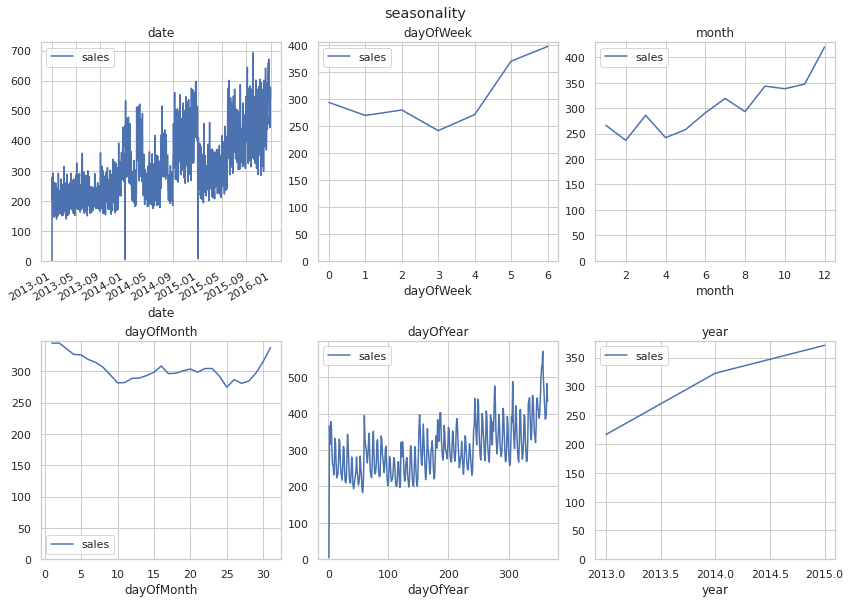

In [9]:
fig, axes=plt.subplots(2,3,constrained_layout=True)
fig.suptitle("seasonality")

for i,unit in enumerate(dateUnits): 
    train_df.groupby(unit).mean()[["sales"]].plot.line(title=unit,ylim=(0),ax=axes[i//3,i%3])

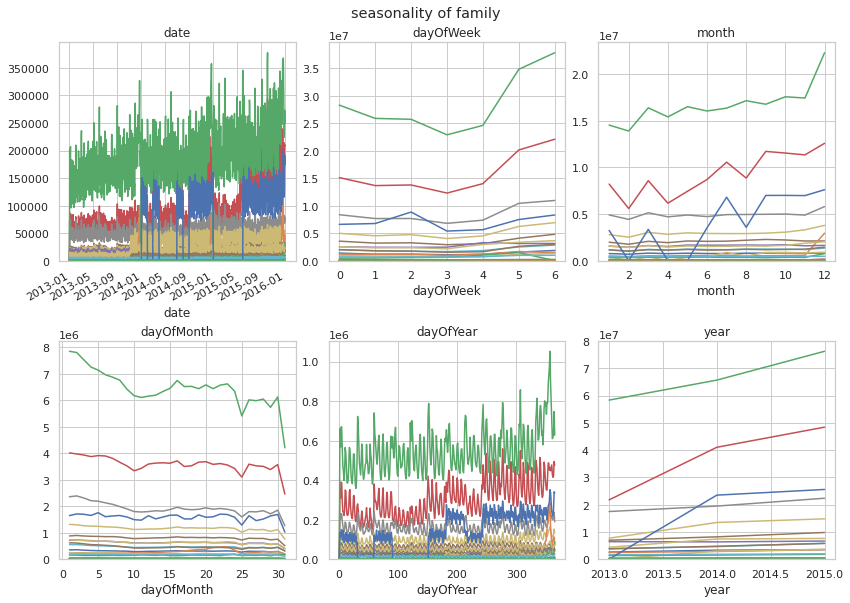

In [10]:
fig, axes=plt.subplots(2,3,constrained_layout=True)
fig.suptitle("seasonality of family")

for i,unit in enumerate(dateUnits): 
    train_df.groupby([unit,"family"],as_index=False).sum().pivot(index=unit,columns="family",values="sales").plot.line(title=unit,ylim=(0),ax=axes[i//3,i%3],legend=False)

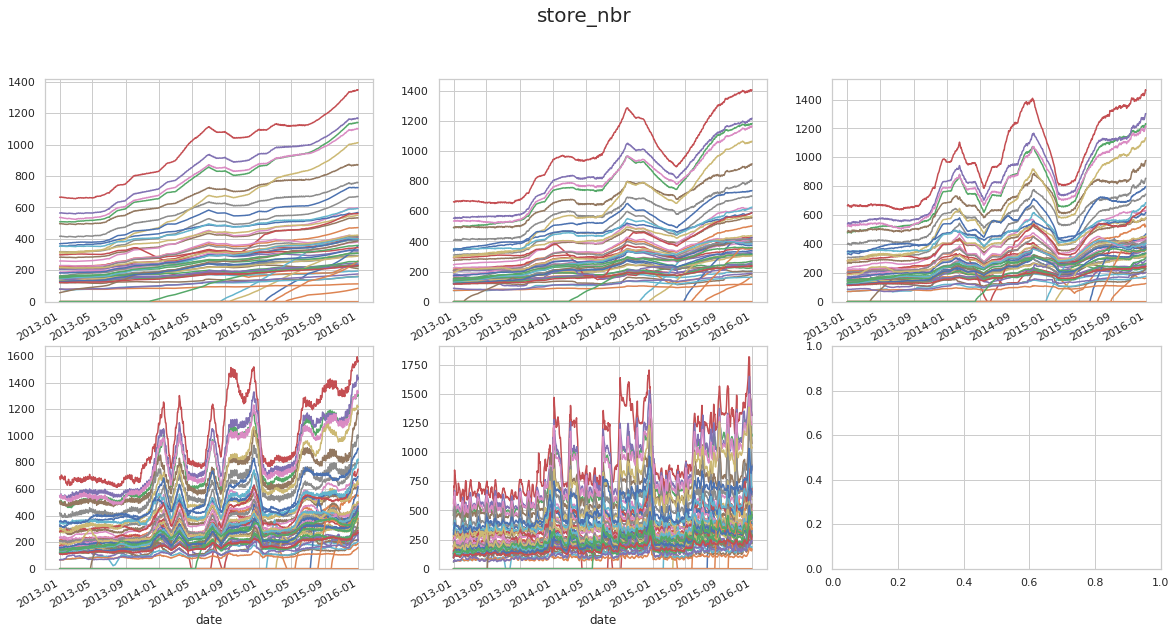

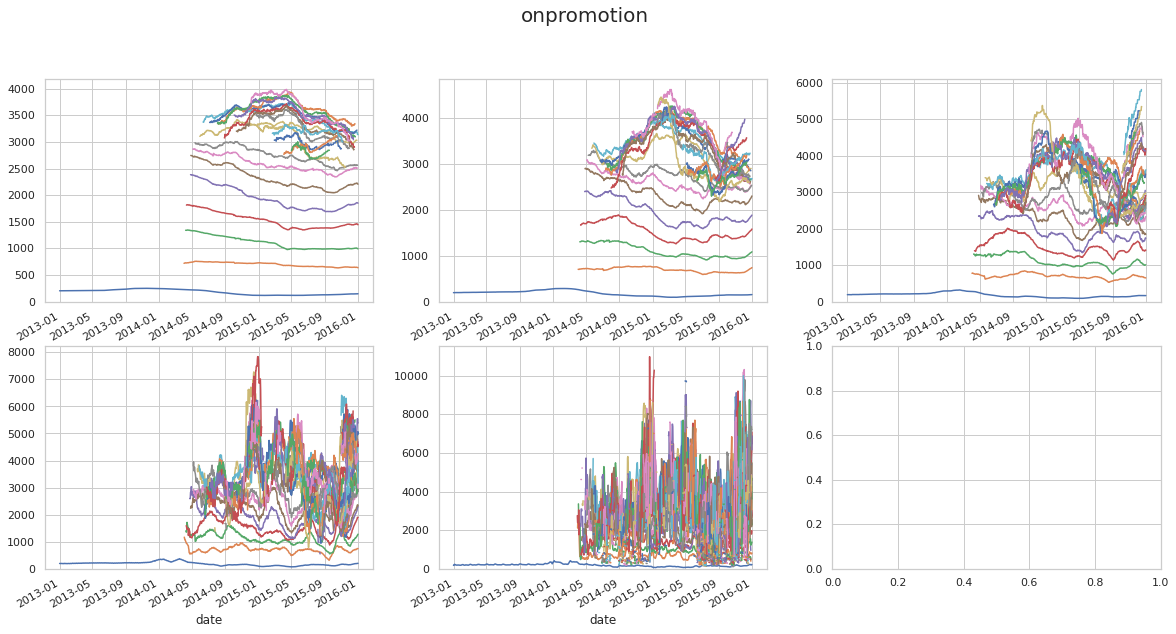

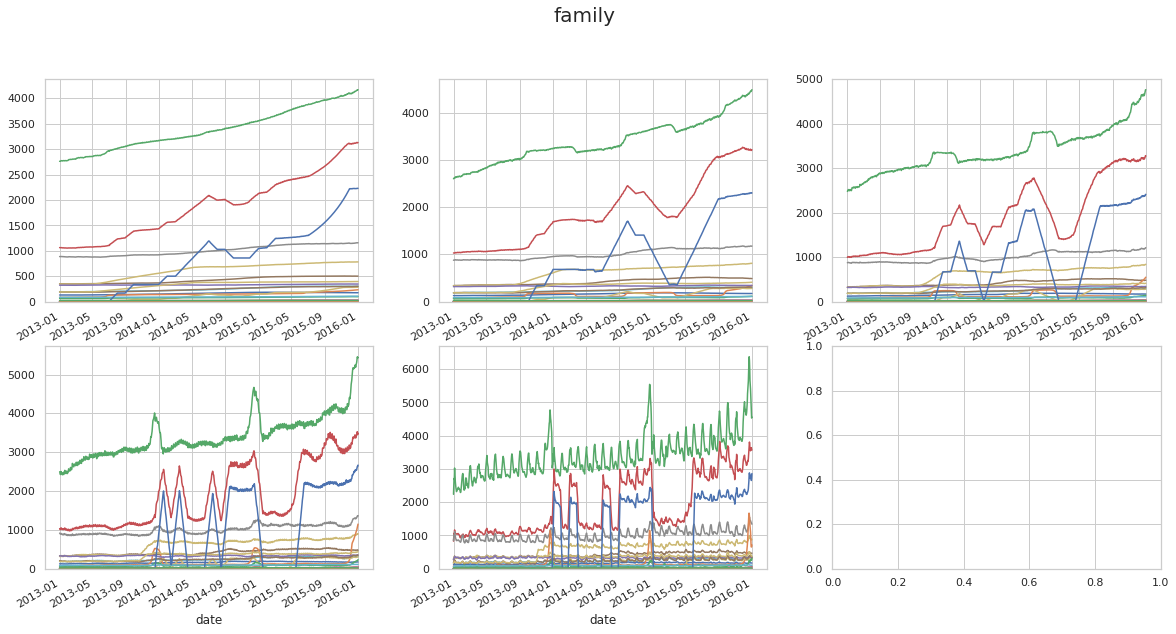

In [11]:
for i in ["store_nbr","onpromotion","family"]:
    moving_average(train_df,i)

## Product

In [12]:
train_df.groupby("family").sum()[["sales"]].sort_values("sales",ascending=False)

,sales
family,
GROCERY I,2.002353e+08
BEVERAGES,1.112542e+08
CLEANING,5.939355e+07
PRODUCE,4.918118e+07
DAIRY,3.606482e+07
BREAD/BAKERY,2.504097e+07
MEATS,1.953504e+07
POULTRY,1.950005e+07
DELI,1.449255e+07


In [13]:
train_df=train_df[train_df["family"]!="BOOKS"]

<AxesSubplot:>

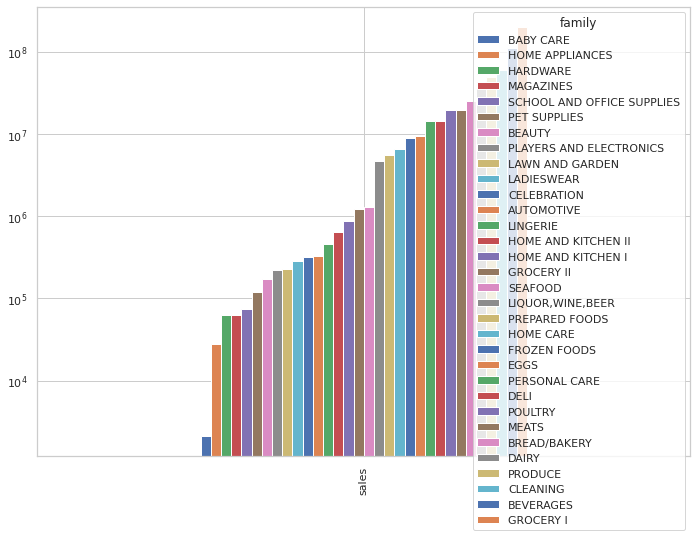

In [14]:
train_df.groupby("family").sum()[["sales"]].sort_values("sales").transpose().plot.bar(logy=True)

In [15]:
train_df.groupby(["date","family"],as_index=False).sum().pivot(index="date",columns="family",values="sales")

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,180.58900,0.0,186.0,143.0,71.090000,46.0,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.00000,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,26246.31900,0.0,74629.0,23381.0,15754.500000,10932.0,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.00000,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,18456.48002,0.0,55893.0,18001.0,11172.455000,7358.0,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.00000,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,16721.96901,0.0,52064.0,18148.0,10143.209000,6760.0,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.00000,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,22367.76108,0.0,70128.0,23082.0,13734.945010,8576.0,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.00000,0.0,1245.637004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,566.0,14.0,365.0,193941.0,25052.22608,613.0,74554.0,43690.0,15783.678004,9282.0,...,395.0,17337.202035,23799.0,452.0,923.0,19384.818020,5318.827016,115628.07210,70.0,1065.620998
2015-12-28,467.0,13.0,292.0,169404.0,22886.31700,742.0,68327.0,40188.0,14501.377020,9116.0,...,309.0,17337.047950,19174.0,342.0,631.0,16296.316996,4760.720997,115887.65298,63.0,959.607994
2015-12-29,470.0,10.0,269.0,182087.0,23777.92200,851.0,72101.0,44035.0,15927.730000,8471.0,...,382.0,18735.067998,18731.0,333.0,641.0,18679.273040,5421.248024,136059.71213,57.0,969.451001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


<AxesSubplot:xlabel='family', ylabel='family'>

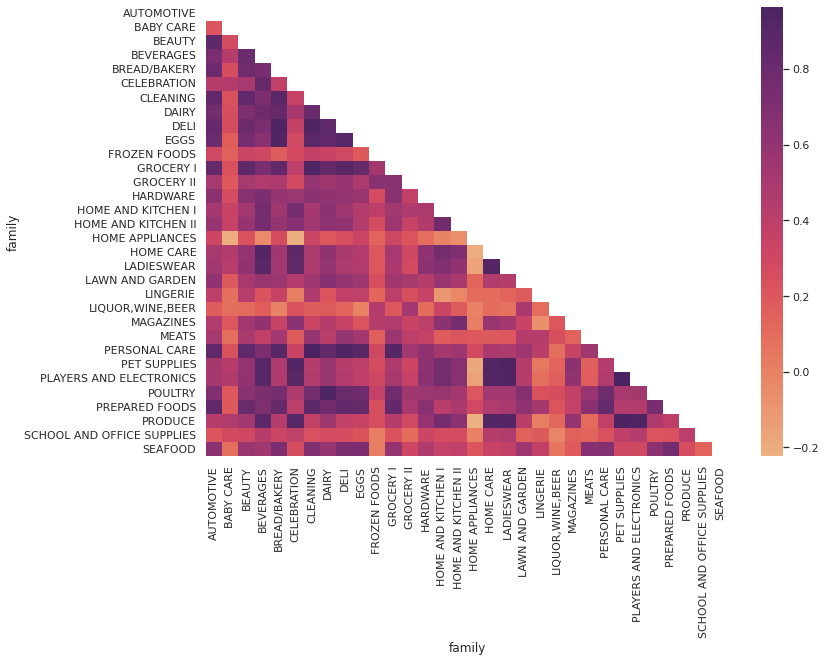

In [16]:
corr_matrix=train_df.groupby(["date","family"],as_index=False).sum().pivot(index="date",columns="family",values="sales").corr()
corr_matrix.values[[np.arange(len(corr_matrix))]*2] = np.nan
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap="flare",mask=mask)

In [17]:
corr_edge=corr_matrix.rename_axis('family_0').stack().reset_index().sort_values(0,ascending=False).reset_index(drop=True)[::2]

In [18]:
corr_edge.head()

,family_0,family,0
0,CLEANING,PERSONAL CARE,0.964609
2,PRODUCE,PET SUPPLIES,0.958590
4,PLAYERS AND ELECTRONICS,PET SUPPLIES,0.958257
6,PLAYERS AND ELECTRONICS,PRODUCE,0.947476
8,BREAD/BAKERY,DELI,0.944762


In [19]:
corr_edge["fam"]=corr_edge["family_0"] + " - "+corr_edge["family"]

<AxesSubplot:xlabel='fam'>

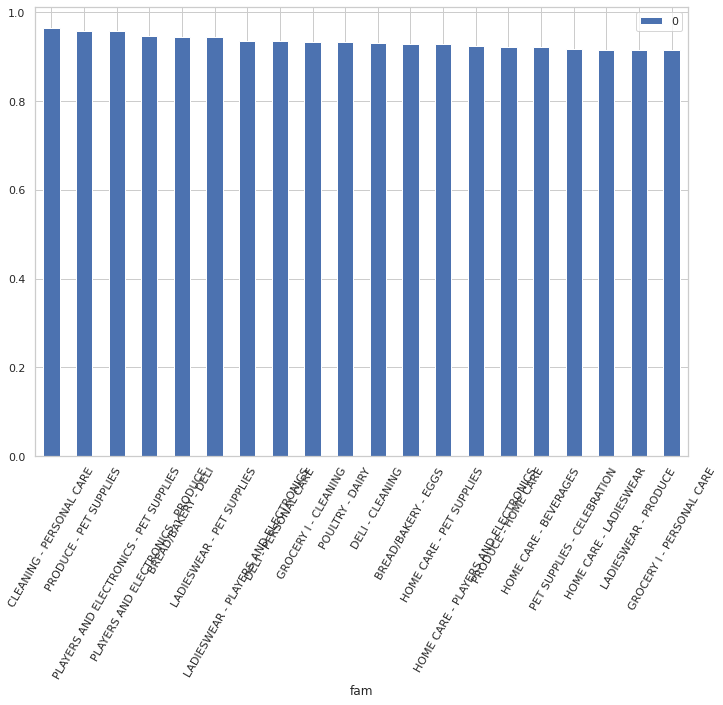

In [20]:
corr_edge[:20].plot.bar(x="fam",y=0,rot=60)

In [21]:
monthly=train_df.copy()
monthly["date"]=monthly["year"].astype(str)+"-"+monthly["month"].astype(str)

In [22]:
store_open=monthly.groupby(["date","store_nbr"],as_index=False).sum().pivot(index="date",columns="store_nbr",values="sales").cumsum()
store_open=store_open/store_open
store_open=store_open.transpose().fillna(0).stack().reset_index()
store_open.columns=["store_nbr","date_month","is_open"]

In [23]:
train_df["date_month"]=train_df["year"].astype(str) +"-" + train_df["month"].astype(str)

In [24]:
train_df.shape

(1886976, 12)

In [25]:
train_df=train_df.merge(store_open)
train_df=train_df.merge(stores_df)
train_df=train_df.merge(transaction_df,how="left")
train_df=train_df.merge(oil_df,how="left")

In [26]:
train_df.tail()

,id,date,store_nbr,family,sales,onpromotion,dayOfWeek,month,dayOfMonth,dayOfYear,year,date_month,is_open,city,state,type,cluster,transactions,dcoilwtico
1886971,1945939,2015-12-31,9,POULTRY,734.391,0,3,12,31,365,2015,2015-12,1.0,Quito,Pichincha,B,6,2972.0,37.13
1886972,1945940,2015-12-31,9,PREPARED FOODS,98.888,0,3,12,31,365,2015,2015-12,1.0,Quito,Pichincha,B,6,2972.0,37.13
1886973,1945941,2015-12-31,9,PRODUCE,2888.340,0,3,12,31,365,2015,2015-12,1.0,Quito,Pichincha,B,6,2972.0,37.13
1886974,1945942,2015-12-31,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,3,12,31,365,2015,2015-12,1.0,Quito,Pichincha,B,6,2972.0,37.13
1886975,1945943,2015-12-31,9,SEAFOOD,20.340,0,3,12,31,365,2015,2015-12,1.0,Quito,Pichincha,B,6,2972.0,37.13


<AxesSubplot:xlabel='date'>

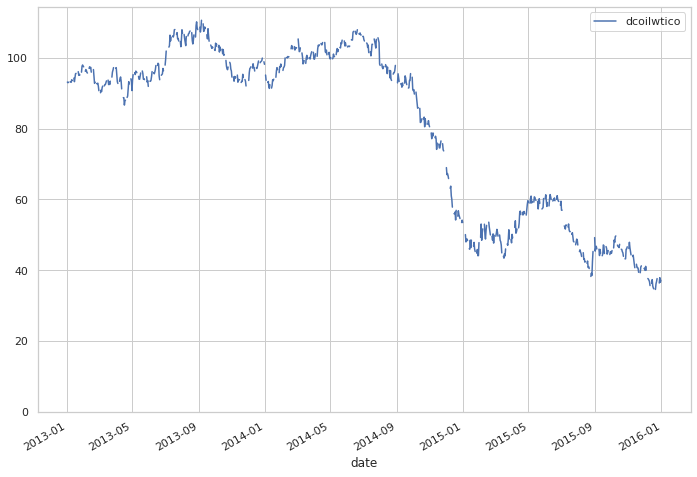

In [27]:
train_df[["date","dcoilwtico"]].plot.line(x="date",y="dcoilwtico",ylim=0)